In [165]:
import plot_utilities as pu
import os
import matplotlib.pyplot as plt
import gymnasium as gym


In [166]:
print("orig")

orig


In [167]:
print("wd")
target_datasets = ["trajectories_min_act.zarr", 
            "trajectories_td_prog.zarr", 
            "trajectories_raceline.zarr"]

gammas = [0.99]
gamma = 0.99
#logdir/f110_rl_0.85_dr_922/"
# logdir_mb = "logdir/f110_rl_0.85_mb_925/"
timesteps = [50,250,1000]
benchmark_date = "1020"


wd


In [168]:
print("Loading env")
F110Env = gym.make('f110_with_dataset-v0',
    # only terminals are available as of tight now 
        **dict(name='f110_with_dataset-v0',
            config = dict(map="Infsaal", num_agents=1),
            render_mode="human")
    )
all_rewards = dict()
rewards_dict = {target: {str(timestep): {} for timestep in timesteps} for target in target_datasets}



Loading env
{'config': {'map': 'Infsaal', 'num_agents': 1}, 'render_mode': 'human'}
Infsaal_map.pgm


/home/fabian/msc/f110_dope/rollouts/f1tenth_gym/gym/f110_gym/envs/integrator.py:13: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(


Infsaal_map.pgm
hi
Infsaal_map.pgm
Infsaal_map.pgm
===
Box([[-0.4189 -5.    ]], [[ 0.4189 20.    ]], (1, 2), float32)
low
20
Box([-30.     -30.      -1.      -1.     -20.     -20.     -20.      -0.4189
   0.5     -1.      -1.    ], [30.     30.      1.      1.     20.     20.     20.      0.4189  2.
  1.      1.    ], (11,), float32)
***********


Compute Crashes and so on from orig dataset

In [169]:
dataset =  F110Env.get_dataset(
                zarr_path= f"/home/fabian/msc/f110_dope/ws_ope/f1tenth_orl_dataset/data/trajectories.zarr", 
                alternate_reward=False,
                include_timesteps_in_obs=True,
                only_terminals=False,
                #clip_trajectory_length=(0,timestep),
                )

/home/fabian/msc/f110_dope/ws_ope/f1tenth_orl_dataset/data/trajectories.zarr


/home/fabian/miniconda3/envs/tf/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_dataset to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_dataset` for environment variables or `env.get_wrapper_attr('get_dataset')` that will search the reminding wrappers.
  logger.warn(


['min_action_weight' 'min_lidar_ray_weight' 'progress_weight'
 'raceline_delta_weight' 'steering_change_weight' 'velocity_change_weight'
 'velocity_weight']
len(model_names) 1402853
Indices: 1402853
[      0       1       2 ... 1402850 1402851 1402852]
(1402853,)
ang_vels_z
lidar_occupancy
linear_vels_x
linear_vels_y
poses_x
poses_y
previous_action
progress_cos
progress_sin
theta_cos
theta_sin
Number of timesteps: 1402853


In [170]:
import plot_utilities as pu
import importlib
# To reload the module:
importlib.reload(pu)

<module 'plot_utilities' from '/home/fabian/msc/f110_dope/ws_ope/plot_utilities.py'>

Statistics for each model:


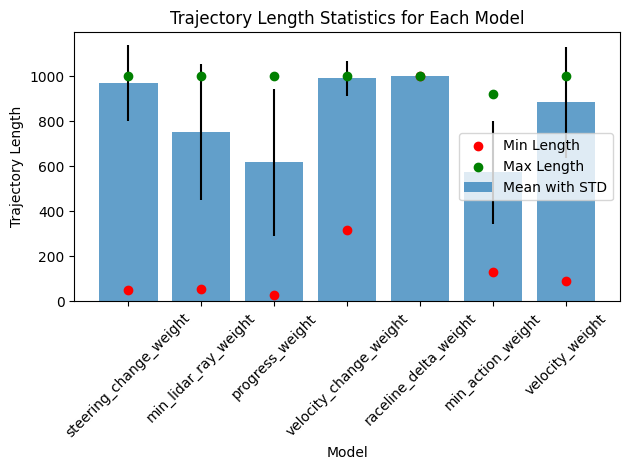

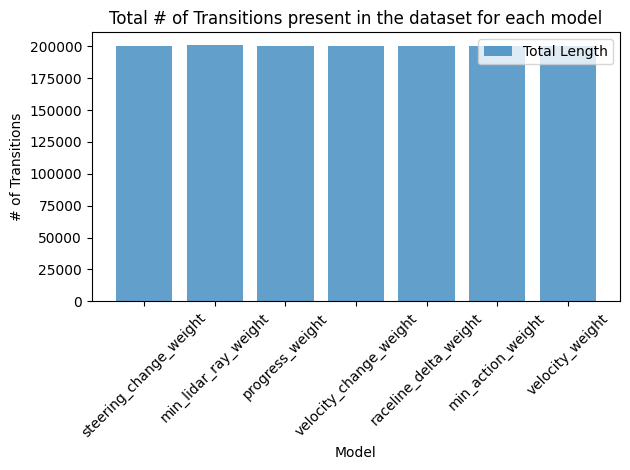

In [171]:
pu.dataset_statistics(dataset)

In [172]:
# split the dataset according to the 
def get_change_indices(model_names):
    change_indices = []
    current_name = model_names[0]
    for idx, name in enumerate(model_names):
        if name != current_name:
            change_indices.append(idx)
            current_name = name
    return change_indices
model_names = dataset["infos"]["model_name"]
change_indices = get_change_indices(model_names) + [len(model_names)]

In [173]:
import numpy as np

In [174]:
print(change_indices)
# count the number of terminals and timeout in each change_indices segment
start = 0
termination_times = {}
for index in change_indices:
    terminals = dataset["terminals"][start:index]
    timeouts = dataset["timeouts"][start:index]
    model_name = dataset["infos"]["model_name"][start]
    #print(model_name)
    #print(f"terminals: {terminals.sum()}")
    #print(f"timeouts: {timeouts.sum()}")
    # Identify the indices where trajectories terminate
    termination_indices = np.where(terminals | timeouts)[0]
    time_diffs = np.diff(termination_indices, prepend=start)

    if model_name not in termination_times:
        termination_times[model_name] = []
    termination_times[model_name].extend(time_diffs)
    start = index

[200464, 401404, 601860, 801928, 1001928, 1202248, 1402853]


In [175]:
print()

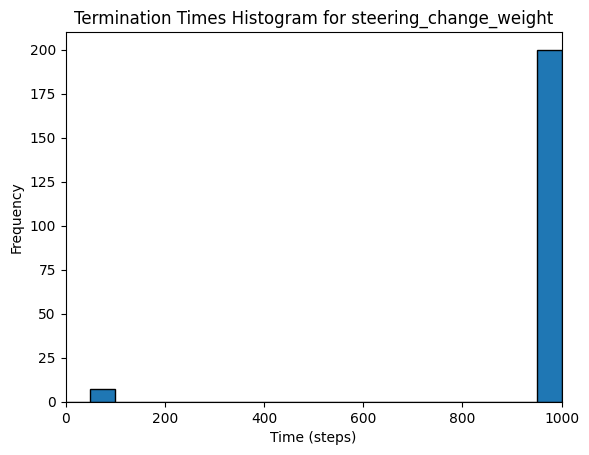

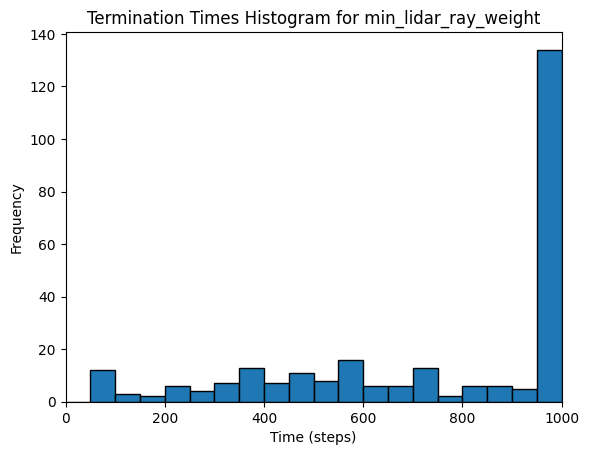

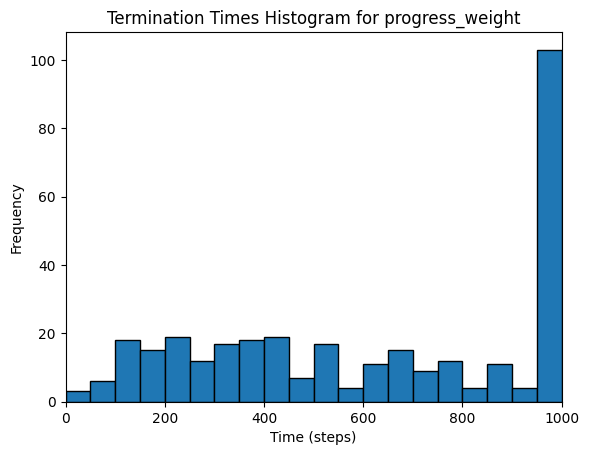

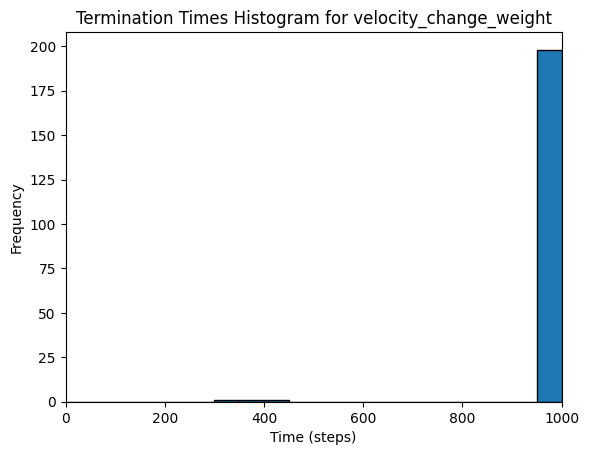

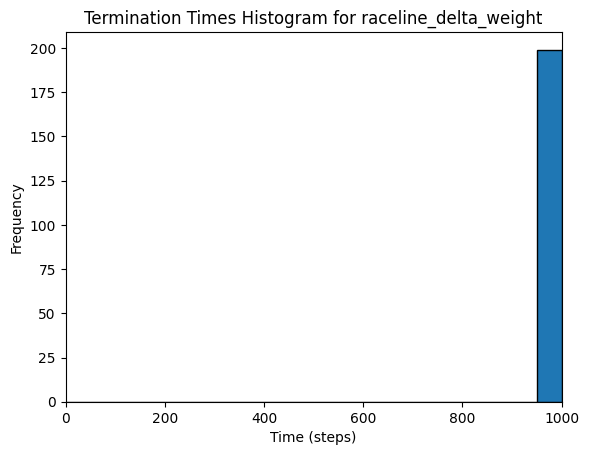

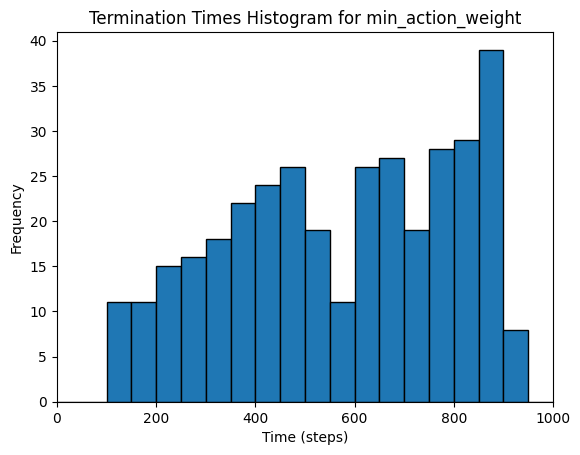

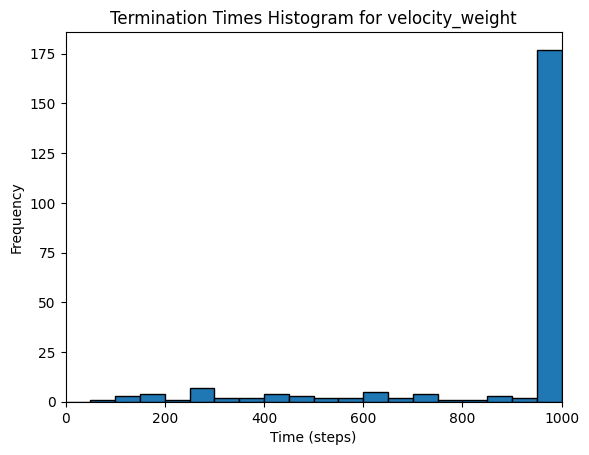

In [176]:
# Plot histograms
# Define bins from 0 to 1000
bins = np.arange(0, 1001, 50)  # creates an array [0, 1, 2, ..., 1000]

# Plot histograms
for model_name, times in termination_times.items():
    plt.figure()
    plt.hist(times, bins=bins, edgecolor='black')
    plt.title(f'Termination Times Histogram for {model_name}')
    plt.xlabel('Time (steps)')
    plt.ylabel('Frequency')
    plt.xlim(0, 1000)  # Optional: to set x-axis limits to (0, 1000)
    plt.show()

# Compute the Ground Truths


In [177]:
for i, target in enumerate(target_datasets):
    for timestep in timesteps:
        # load the dataset
        print("/home/fabian/msc/f110_dope/ws_ope/f1tenth_orl_dataset/data/{target}")
        dataset =  F110Env.get_dataset(
                        zarr_path= f"/home/fabian/msc/f110_dope/ws_ope/f1tenth_orl_dataset/data/{target}", 
                        alternate_reward=True,
                        include_timesteps_in_obs=True,
                        only_terminals=True,
                        clip_trajectory_length=(0,timestep),
                        )
        #print("target:", {target})
        returns, std = pu.compute_returns(dataset, gamma)
        #print(returns, std)
        for key in returns.keys():
            rewards_dict[target][str(timestep)][key] = {}
            rewards_dict[target][str(timestep)][key]["mean"] = returns[key]
            rewards_dict[target][str(timestep)][key]["std"] = std[key]
        
all_rewards["ground_truth"] = rewards_dict
print(all_rewards)

/home/fabian/msc/f110_dope/ws_ope/f1tenth_orl_dataset/data/{target}
/home/fabian/msc/f110_dope/ws_ope/f1tenth_orl_dataset/data/trajectories_min_act.zarr


/home/fabian/miniconda3/envs/tf/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_dataset to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_dataset` for environment variables or `env.get_wrapper_attr('get_dataset')` that will search the reminding wrappers.
  logger.warn(


['min_action_weight' 'min_lidar_ray_weight' 'progress_weight'
 'raceline_delta_weight' 'steering_change_weight' 'velocity_change_weight'
 'velocity_weight']
len(model_names) 1402853
Indices: 1402853
Using alternate reward
[      0       1       2 ... 1402850 1402851 1402852]
(1402853,)
ang_vels_z
lidar_occupancy
linear_vels_x
linear_vels_y
poses_x
poses_y
previous_action
progress_cos
progress_sin
theta_cos
theta_sin
Number of timesteps: 88871
88871
[10350, 23750, 39971, 50071, 60071, 77571, 88871]
/home/fabian/msc/f110_dope/ws_ope/f1tenth_orl_dataset/data/{target}
/home/fabian/msc/f110_dope/ws_ope/f1tenth_orl_dataset/data/trajectories_min_act.zarr
['min_action_weight' 'min_lidar_ray_weight' 'progress_weight'
 'raceline_delta_weight' 'steering_change_weight' 'velocity_change_weight'
 'velocity_weight']
len(model_names) 1402853
Indices: 1402853
Using alternate reward
[      0       1       2 ... 1402850 1402851 1402852]
(1402853,)
ang_vels_z
lidar_occupancy
linear_vels_x
linear_vels_y
po

In [178]:
import importlib
# reload pu
importlib.reload(pu)

<module 'plot_utilities' from '/home/fabian/msc/f110_dope/ws_ope/plot_utilities.py'>

In [179]:
def traverse_logdir(logdir,method='dr', tag_pred='train/pred returns',tag_std='train/pred stds', minimum_evals=3):
    dict = {}
    # first append the method to the logdir
    logdir = os.path.join(logdir, method)
    # now lets check the target rewards available
    target_rewards = os.listdir(logdir)
    # for each target reward we now descent into the directory
    for reward in target_rewards:
        dict[reward] = {}
        # now we check the available lengths
        for length in os.listdir(os.path.join(logdir, reward)):
            dict[reward][length] = {}
            for agent in os.listdir(os.path.join(logdir, reward, length)):
                dict[reward][length][agent] = {'mean': [], 'std': []}
                # now we check the available runs
                isFilled = False
                for run in os.listdir(os.path.join(logdir, reward, length, agent)):
                    # each of the runs is a folder, that we have to descent into and hand 
                    # over to get dict from tf
                    folder_path = os.path.join(logdir, reward, length, agent, run)
                    # make sure to only use folders not files
                    if not os.path.isdir(folder_path):
                        continue
                    data = pu.get_dict_from_tf(folder_path, tag=tag_pred)
                    data_std = pu.get_dict_from_tf(folder_path, tag=tag_std)
                    # print(len(data))
                    if len(data) >= minimum_evals:
                        dict[reward][length][agent]['mean'].append(data)
                        dict[reward][length][agent]['std'].append(data_std)
                        isFilled = True
                if not isFilled:
                    dict[reward][length].pop(agent)
    return dict

In [202]:
print(all_rewards)
all_rewards_gt_only = all_rewards.copy()

{'ground_truth': {'trajectories_min_act.zarr': {'50': {'steering_change_weight': {'mean': 0.30340109293978706, 'std': 0.0645990869593182}, 'min_lidar_ray_weight': {'mean': 0.301704263471454, 'std': 0.04721196529213478}, 'progress_weight': {'mean': 0.3010451974624502, 'std': 0.06056464584802911}, 'velocity_change_weight': {'mean': 0.30574588942817466, 'std': 0.060448676225598234}, 'raceline_delta_weight': {'mean': 0.29819392809635725, 'std': 0.07318082791984214}, 'min_action_weight': {'mean': 0.3450604762538443, 'std': 0.03982212226219459}, 'velocity_weight': {'mean': 0.3134397790521909, 'std': 0.04354444130728709}}, '250': {'steering_change_weight': {'mean': 0.6991014285022887, 'std': 0.0994450414704106}, 'min_lidar_ray_weight': {'mean': 0.6961564047979116, 'std': 0.09533356958631917}, 'progress_weight': {'mean': 0.6657085219283688, 'std': 0.08696686550897513}, 'velocity_change_weight': {'mean': 0.7178641280466285, 'std': 0.07281802393767813}, 'raceline_delta_weight': {'mean': 0.698065

In [219]:
import numpy as np
def post_process_rewards(rewards_dict):
    for method in rewards_dict.keys():
        if method=="ground_truth":
            continue
        for target in rewards_dict[method].keys():
            for timestep in rewards_dict[method][target].keys():
                for agent in rewards_dict[method][target][str(timestep)].keys():
                    unprocessed_means = rewards_dict[method][target][str(timestep)][agent]['mean']
                    unprocessed_stds = rewards_dict[method][target][str(timestep)][agent]['std']
                    processed_means = []
                    processed_stds = []
                    if len(unprocessed_means) == 0:
                        # del rewards_dict[method][target][str(timestep)][agent]
                        continue
                    if unprocessed_means[0] == []:
                        continue
                    for mean in unprocessed_means:
                        if len(mean) == 0:
                            processed_means.append(0)
                        else:
                            processed_means.append(mean[-1])

                    processed_means = np.array(processed_means)
                    rewards_dict[method][target][str(timestep)][agent]['mean'] = np.mean(processed_means)
                    processed_means_std = np.std(processed_means)
                    stds_zero =False
                    for std in unprocessed_stds:
                        if len(std) == 0:
                            stds_zero = True
                            break
                        processed_stds.append(std[-1])
                    if stds_zero == True:
                        rewards_dict[method][target][str(timestep)][agent]['std'] = processed_means_std
                    else:
                        processed_stds = np.array(processed_stds)
                        rewards_dict[method][target][str(timestep)][agent]['std'] = np.mean(processed_stds)
    return rewards_dict

In [220]:
logdir = "logdir/0211"
minimum_evals = 2
all_rewards["dr"] = traverse_logdir(logdir, method='dr', 
                                    tag_pred='train/pred returns',
                                    tag_std='train/pred stds',
                                    minimum_evals=minimum_evals)

# fqe is also computed during dr computation
# logdir/0211 is good
#all_rewards["fqe"] = traverse_logdir(logdir, method='dr',
#                                     tag_pred='train/pred returns (fqe)',
#                                    tag_std='std_deviation returns (fqe)',
#                                    minimum_evals=minimum_evals)

all_rewards["fqe"] = traverse_logdir("logdir_torch/2011", method='fqe',
                                     tag_pred='eval/mean_fqe',
                                    tag_std='eval/std_fqe',
                                    minimum_evals=minimum_evals)

In [221]:
all_rewards["fqe_mb"] = traverse_logdir("logdir_torch/2011", method='fqe_mb_multistep',
                                     tag_pred='eval/mean_fqe_mb',
                                    tag_std='eval/std_fqe_mb',
                                    minimum_evals=0)

In [222]:
all_rewards["fqe_mb_single"] = traverse_logdir("logdir_torch/2011", method='fqe_mb',
                                     tag_pred='eval/mean_fqe_mb',
                                    tag_std='eval/std_fqe_mb',
                                    minimum_evals=0)

In [223]:
all_rewards["mb"] = traverse_logdir("logdir/1411", method='mb',
                                    tag_pred='train/pred returns',
                                    tag_std='train/pred std',
                                    minimum_evals=0)

In [224]:
all_rewards["fqe_mb_dr"] = traverse_logdir("logdir_torch/2311", method='fqe_mb_dr',
                                    tag_pred='eval/mean_fqe_mb',
                                    tag_std='eval/std_fqe_mb',
                                    minimum_evals=0)
print(all_rewards["fqe_mb_dr"])

{'trajectories_raceline.zarr': {'50': {'progress_weight': {'mean': [[0.29009172320365906]], 'std': [[0.025478895753622055]]}, 'raceline_delta_weight': {'mean': [[0.29530012607574463]], 'std': [[0.02342180907726288]]}, 'min_action_weight': {'mean': [[0.28898000717163086]], 'std': [[0.023699045181274414]]}}, '1000': {'progress_weight': {'mean': [[]], 'std': [[]]}, 'raceline_delta_weight': {'mean': [[]], 'std': [[]]}, 'min_action_weight': {'mean': [[]], 'std': [[]]}}, '250': {'progress_weight': {'mean': [[0.6466136574745178]], 'std': [[0.02538713812828064]]}, 'raceline_delta_weight': {'mean': [[0.6415237188339233]], 'std': [[0.0348677784204483]]}, 'min_action_weight': {'mean': [[0.6181147694587708]], 'std': [[0.05807739123702049]]}}}, 'trajectories_min_act.zarr': {'50': {'progress_weight': {'mean': [[0.26869168877601624]], 'std': [[0.05638756975531578]]}, 'raceline_delta_weight': {'mean': [[0.26568403840065]], 'std': [[0.06136456876993179]]}, 'min_action_weight': {'mean': [[0.317861199378

In [225]:
import pprint
pprint.pprint(all_rewards)

{'dr': {'trajectories_min_act.zarr': {'1000': {'min_action_weight': {'mean': [[0.4834328889846802,
                                                                               0.8994852900505066,
                                                                               0.9202960133552551],
                                                                              [0.5766808986663818,
                                                                               0.880744457244873,
                                                                               0.8837775588035583]],
                                                                     'std': [[],
                                                                             []]},
                                               'progress_weight': {'mean': [[0.42504191398620605,
                                                                             0.7020596265792847,
                                             

In [226]:
all_rewards = post_process_rewards(all_rewards)


In [227]:
import pprint
pprint.pprint(all_rewards)

{'dr': {'trajectories_min_act.zarr': {'1000': {'min_action_weight': {'mean': 0.9020367860794067,
                                                                     'std': 0.01825922727584839},
                                               'progress_weight': {'mean': 0.7388409674167633,
                                                                   'std': 0.00320473313331604},
                                               'raceline_delta_weight': {'mean': 0.7210671603679657,
                                                                         'std': 0.003272801637649536}},
                                      '250': {'min_action_weight': {'mean': 0.8224023977915446,
                                                                    'std': 0.013955077620034523},
                                              'progress_weight': {'mean': 0.6792692343393961,
                                                                  'std': 0.008926433423597032},
                         

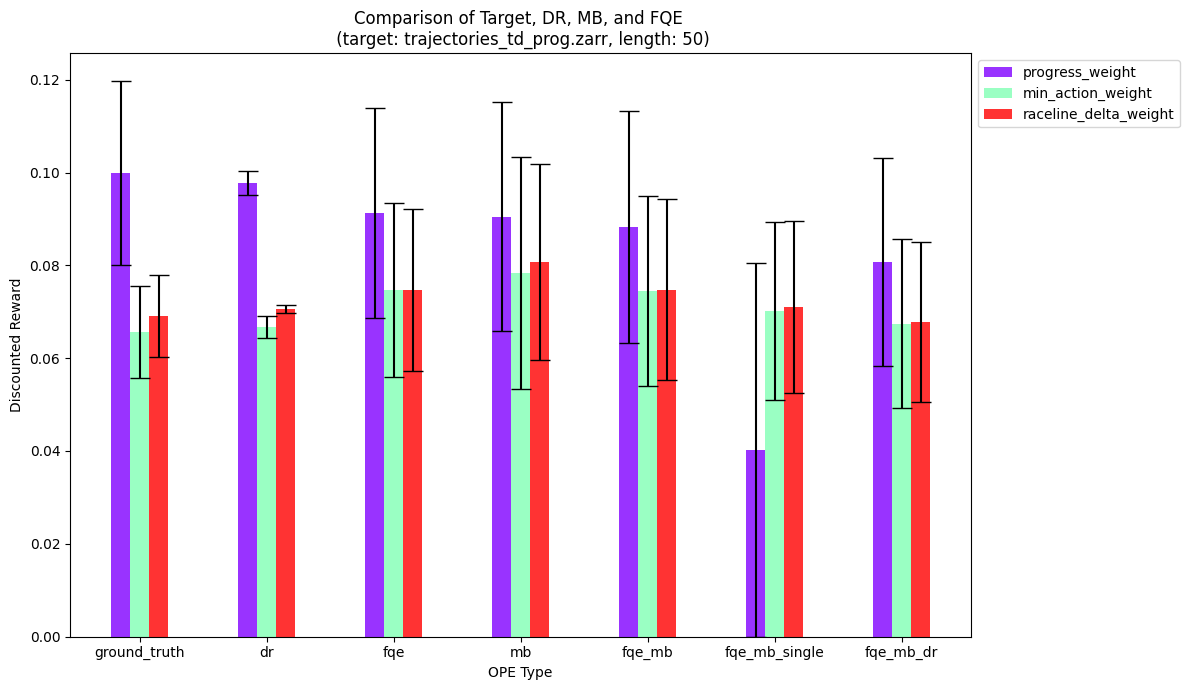

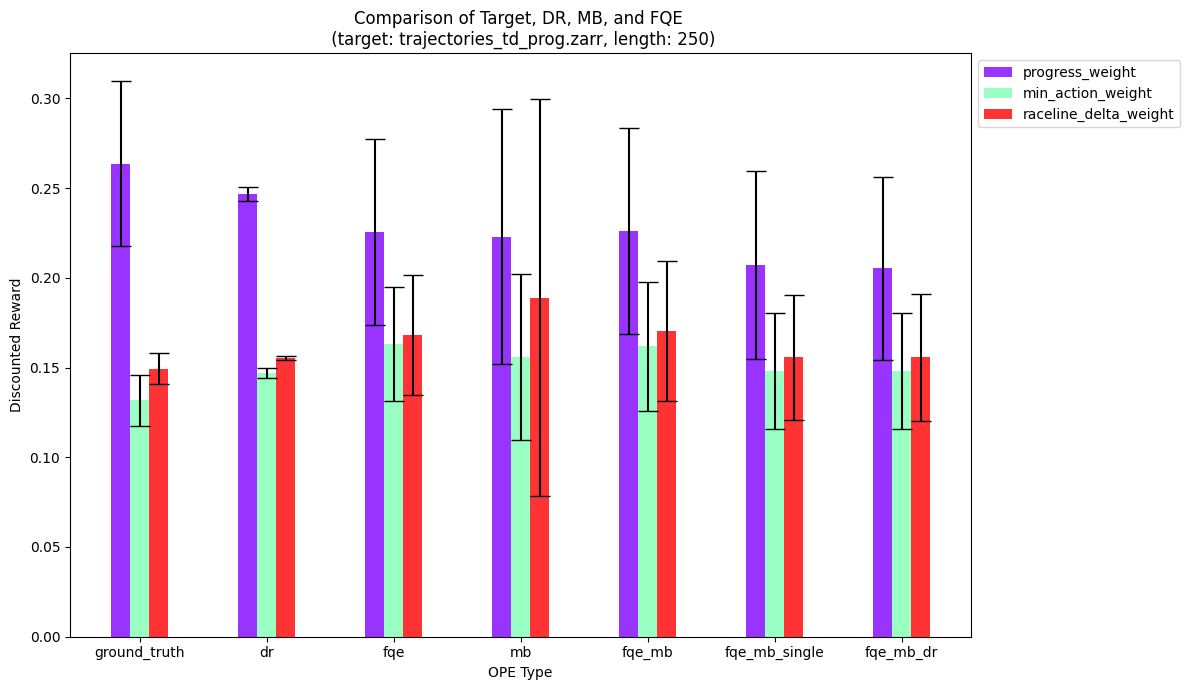

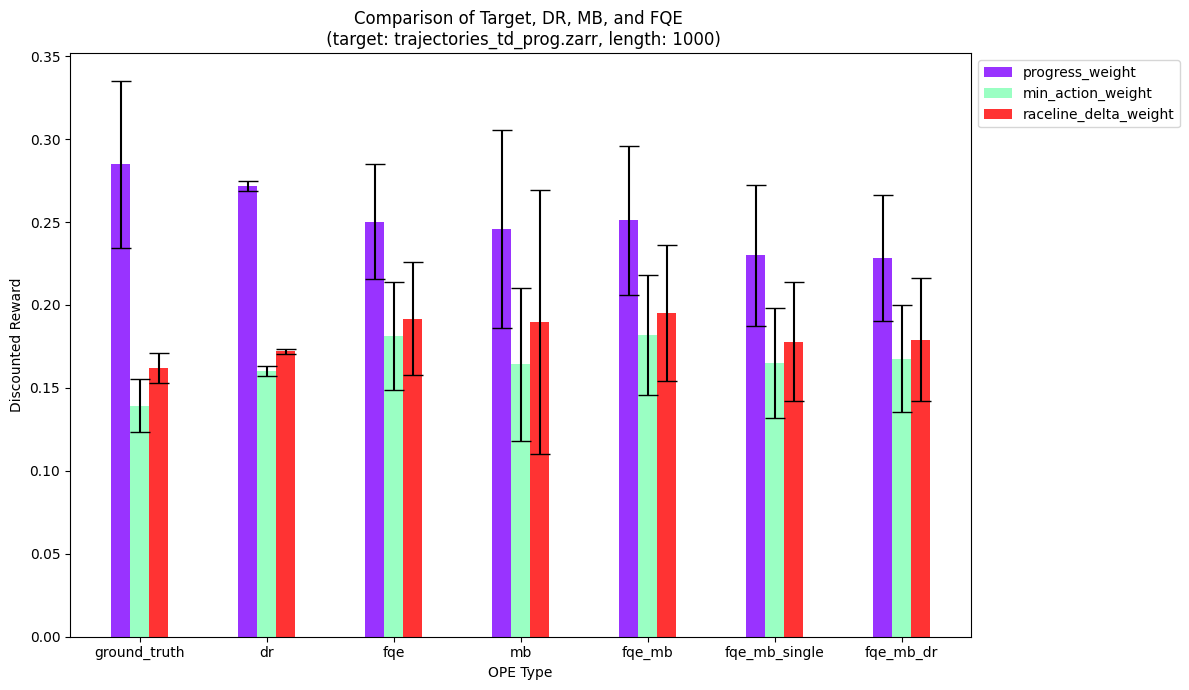

In [228]:
import plot_utilities as pu
import importlib
# To reload the module:
importlib.reload(pu)
lengths = ["50", "250", "1000"] #"1000"]
for length in lengths:
    pu.plot_bars_from_dict(all_rewards, 
                        target="trajectories_td_prog.zarr", 
                        length=length, 
                        methods= ["ground_truth", "dr", "fqe", "mb", "fqe_mb", "fqe_mb_single", "fqe_mb_dr"],
                        sub_keys=["progress_weight", "min_action_weight", "raceline_delta_weight"])


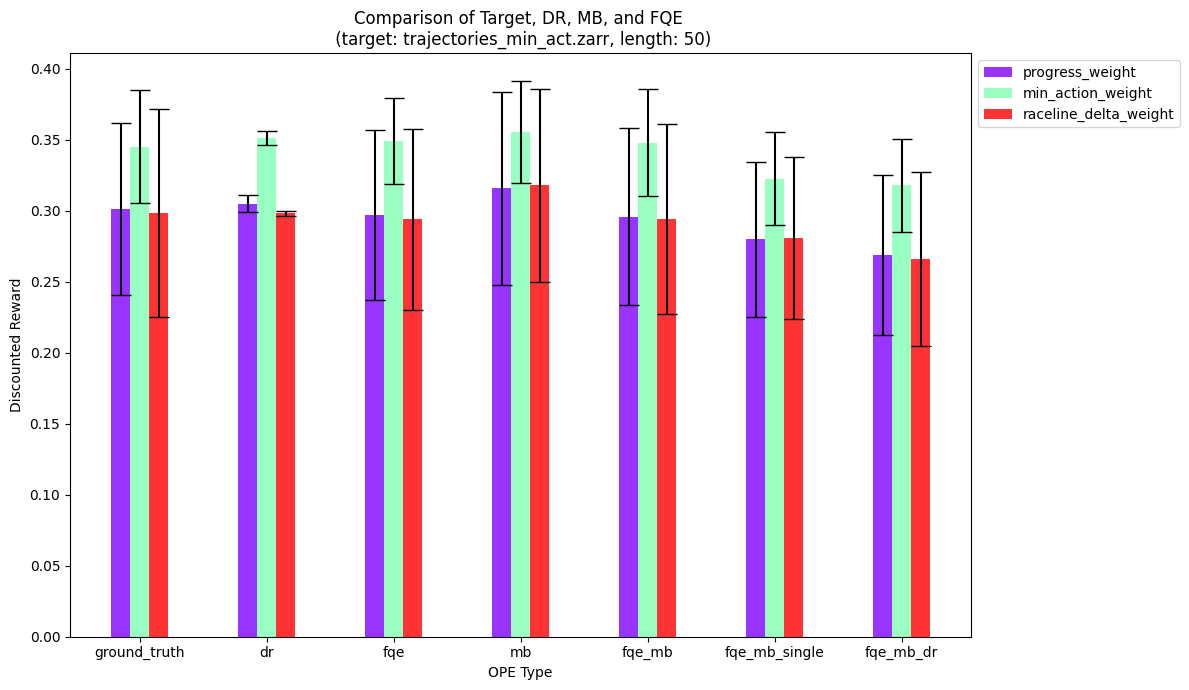

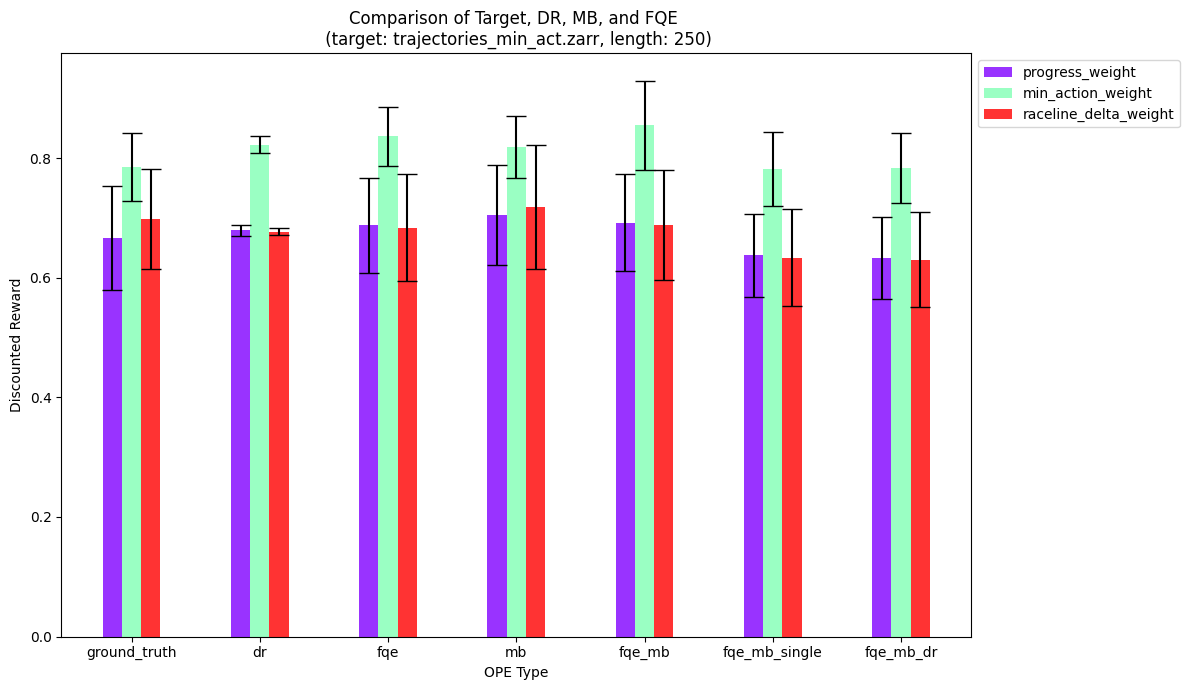

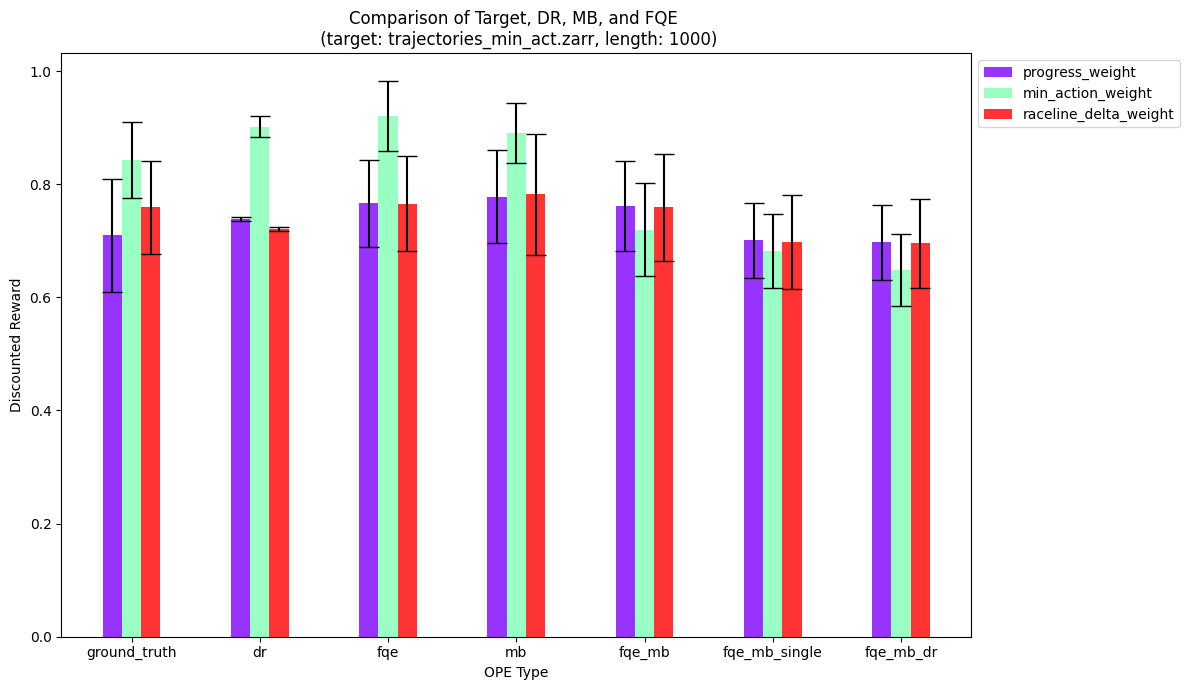

In [229]:
for length in lengths:
    pu.plot_bars_from_dict(all_rewards, 
                        target="trajectories_min_act.zarr", 
                        length=length, 
                        methods= ["ground_truth", "dr", "fqe", "mb", "fqe_mb", "fqe_mb_single", "fqe_mb_dr"],
                        sub_keys=["progress_weight", "min_action_weight", "raceline_delta_weight"])


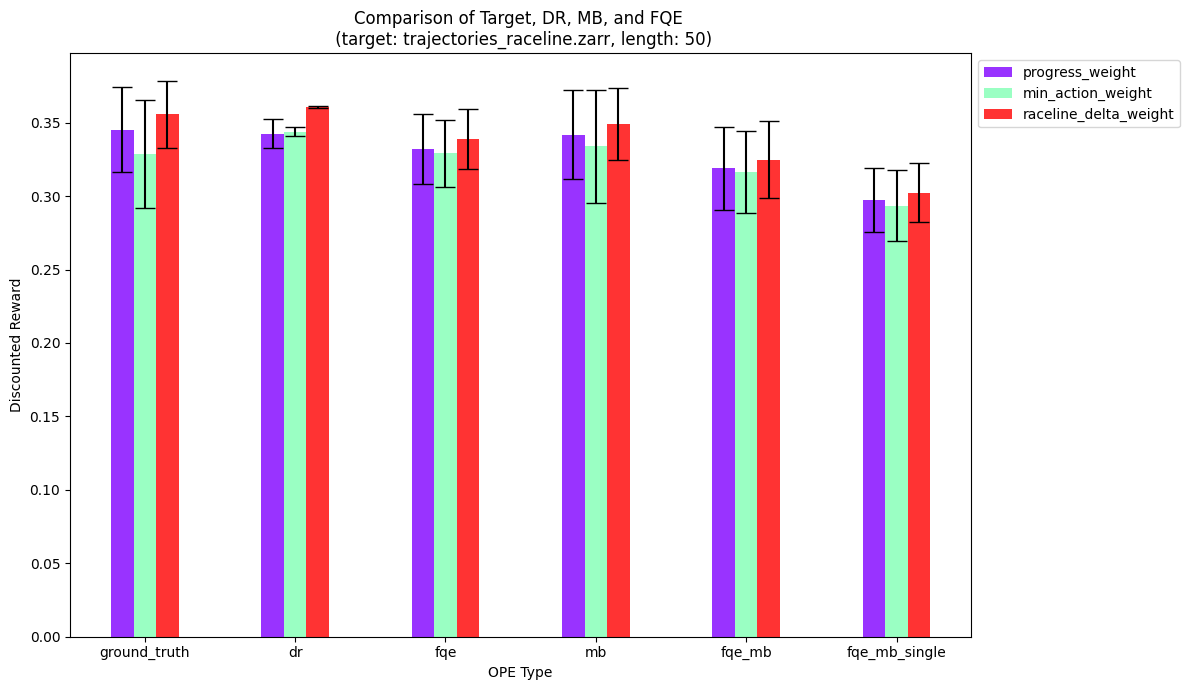

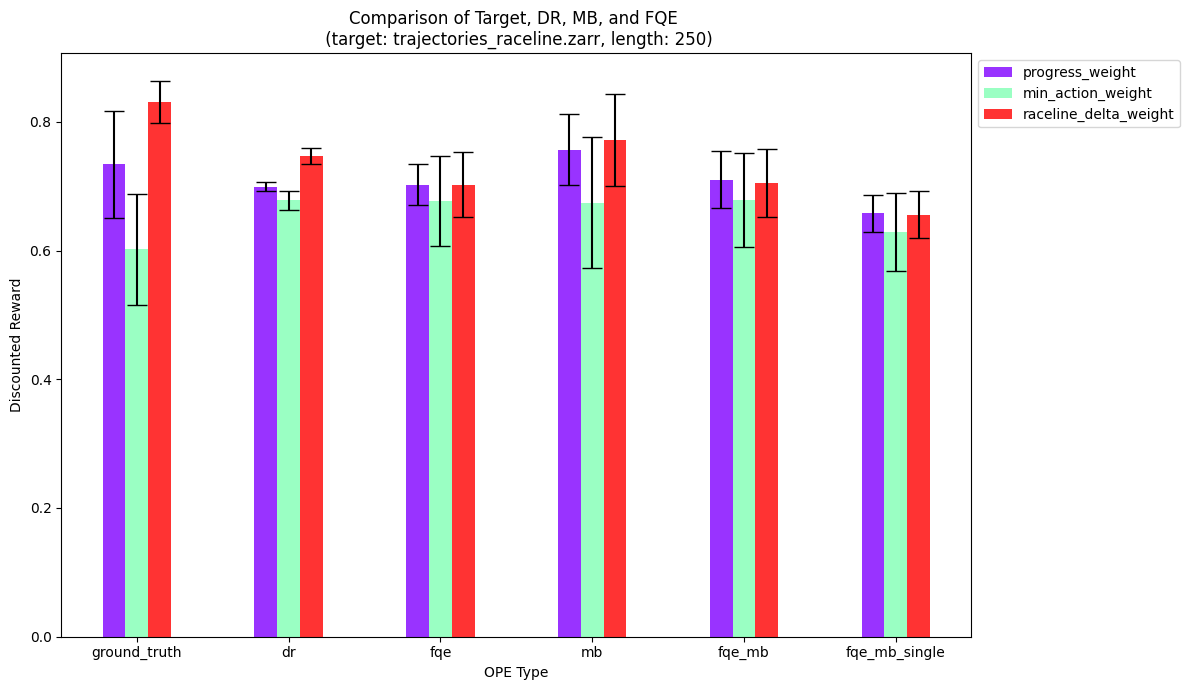

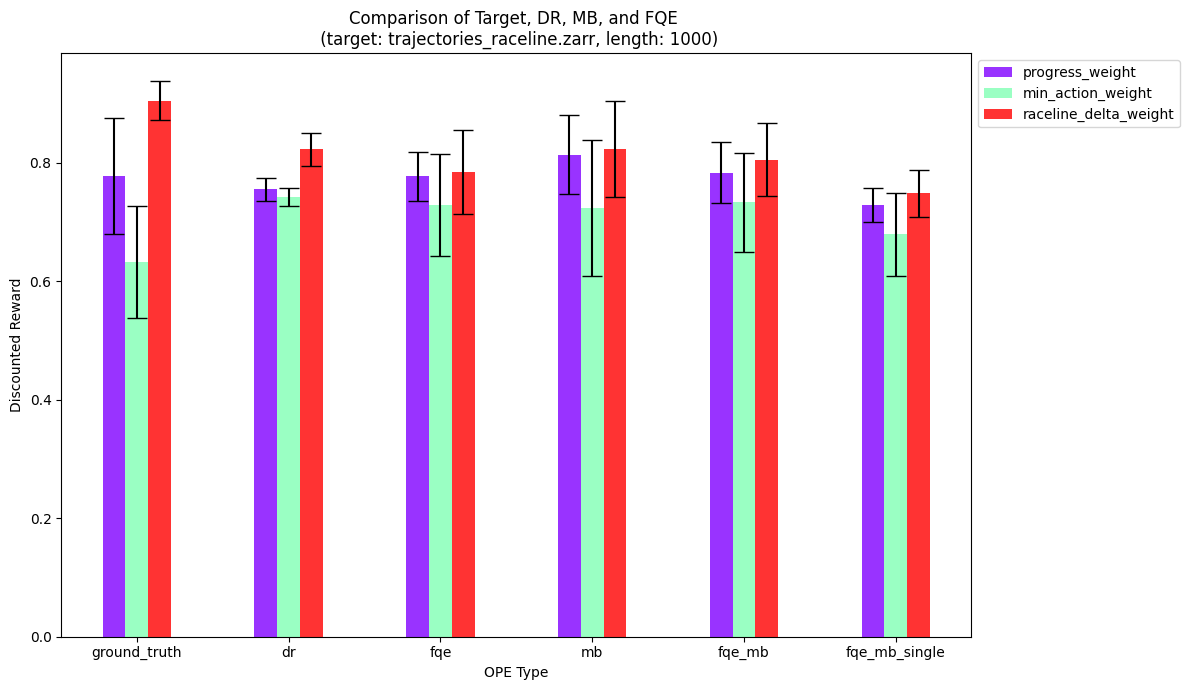

In [131]:
for length in lengths:
    pu.plot_bars_from_dict(all_rewards, 
                        target="trajectories_raceline.zarr", 
                        length=length, 
                        methods= ["ground_truth", "dr", "fqe", "mb", "fqe_mb", "fqe_mb_single", "fqe_mb_dr"],
                        sub_keys=["progress_weight", "min_action_weight", "raceline_delta_weight"])


dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])


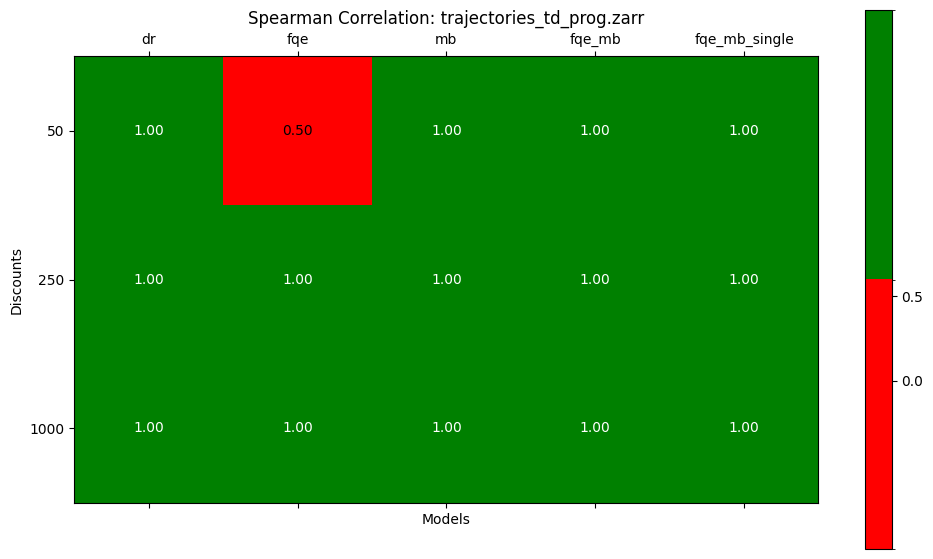

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])


<Figure size 640x480 with 0 Axes>

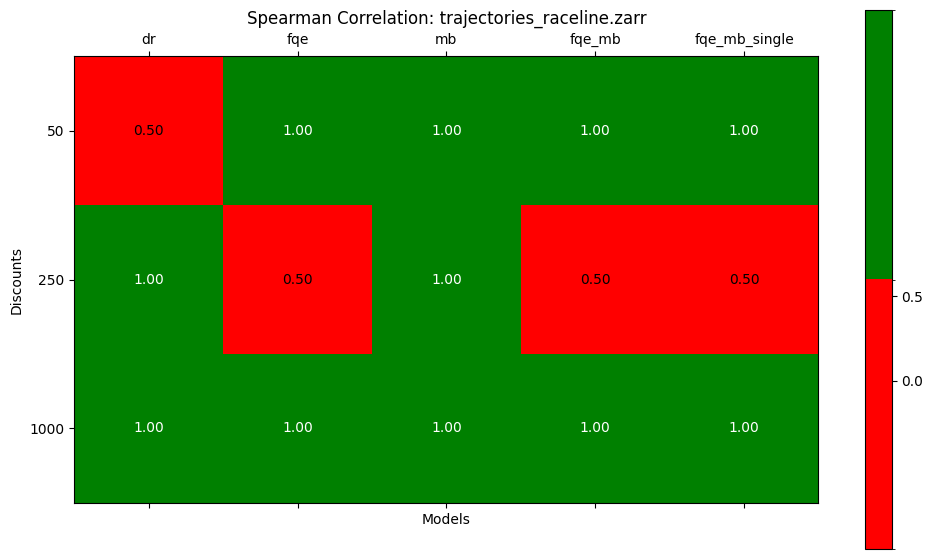

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])


<Figure size 640x480 with 0 Axes>

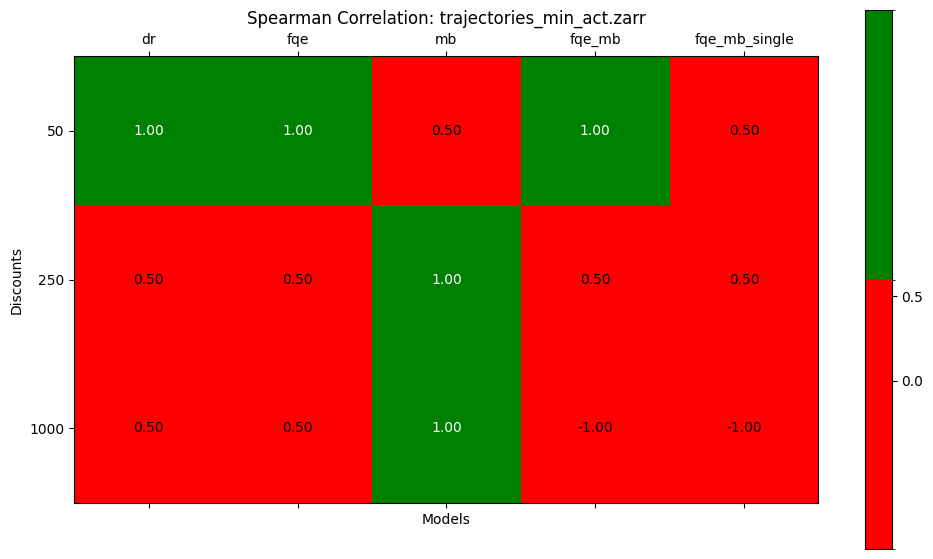

<Figure size 640x480 with 0 Axes>

In [132]:
import plot_utilities as pu
import importlib
# To reload the module:
importlib.reload(pu)


pu.plot_spearman(all_rewards, 
                 target_rewards=["trajectories_td_prog.zarr", "trajectories_raceline.zarr", "trajectories_min_act.zarr"],
                 methods=["dr", "fqe", "mb", "fqe_mb", "fqe_mb_single"],
                 lengths=lengths)

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])
dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])


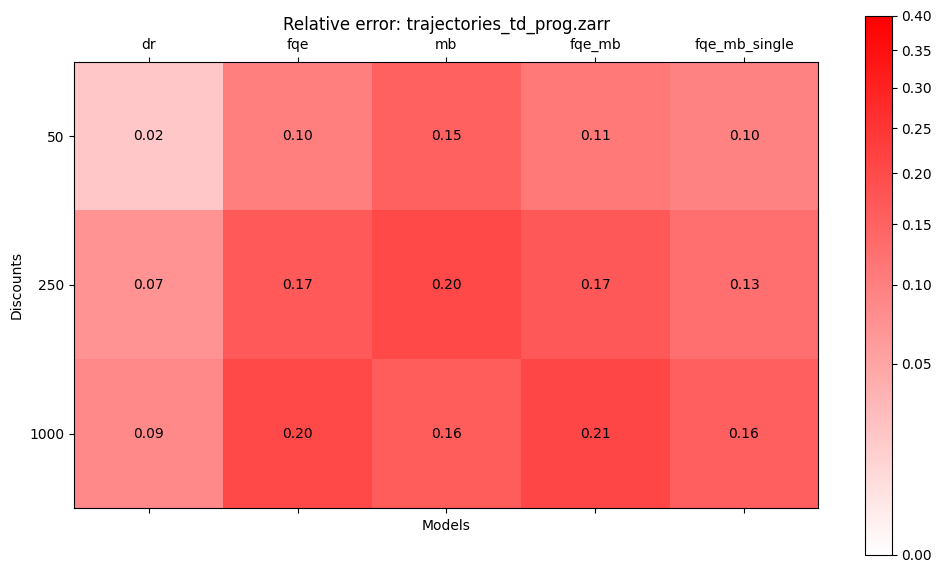

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])
dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])


<Figure size 640x480 with 0 Axes>

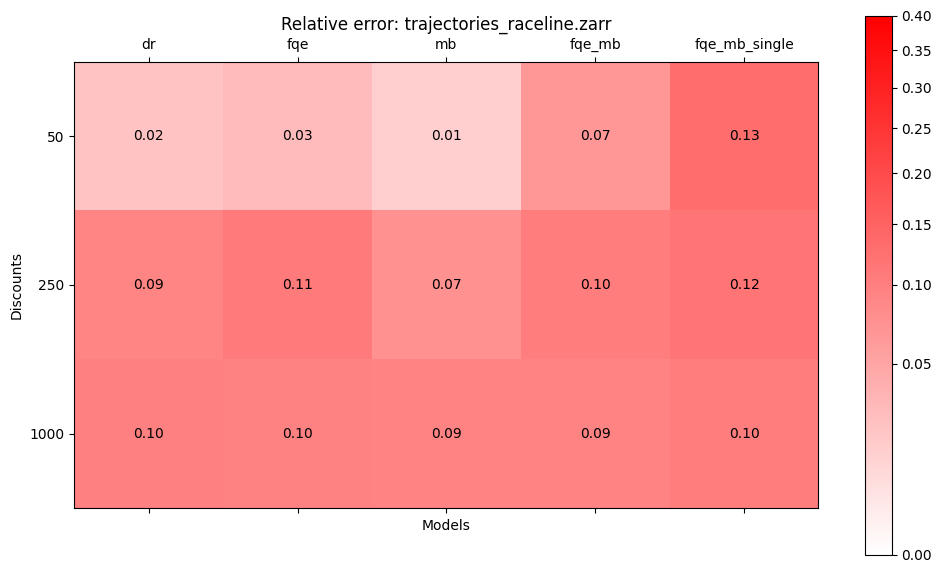

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])
dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])


<Figure size 640x480 with 0 Axes>

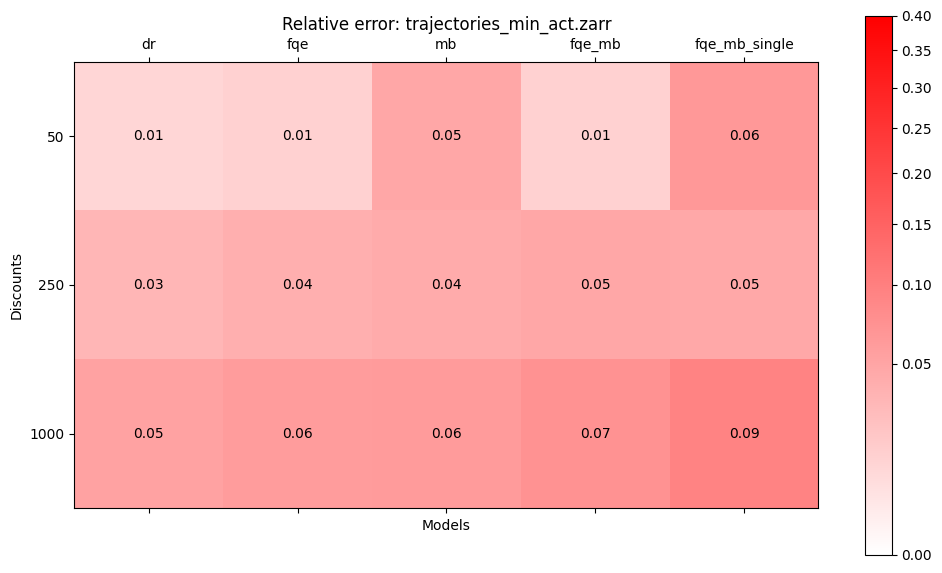

<Figure size 640x480 with 0 Axes>

In [133]:
import plot_utilities as pu
import importlib
# To reload the module:
importlib.reload(pu)


pu.plot_mse(all_rewards, 
                 target_rewards=["trajectories_td_prog.zarr", "trajectories_raceline.zarr", "trajectories_min_act.zarr"],
                 methods=["dr", "fqe", "mb", "fqe_mb", "fqe_mb_single"],
                 lengths=lengths)

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
['50', '250', '1000']


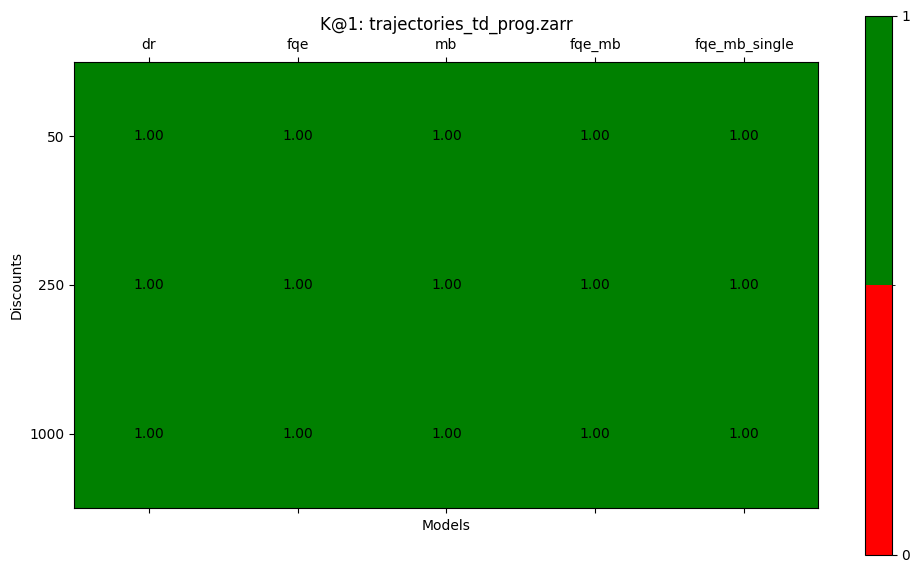

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])
[[1 1 1 1 1]
 [1 0 1 0 0]
 [1 1 1 1 1]]
['50', '250', '1000']


<Figure size 640x480 with 0 Axes>

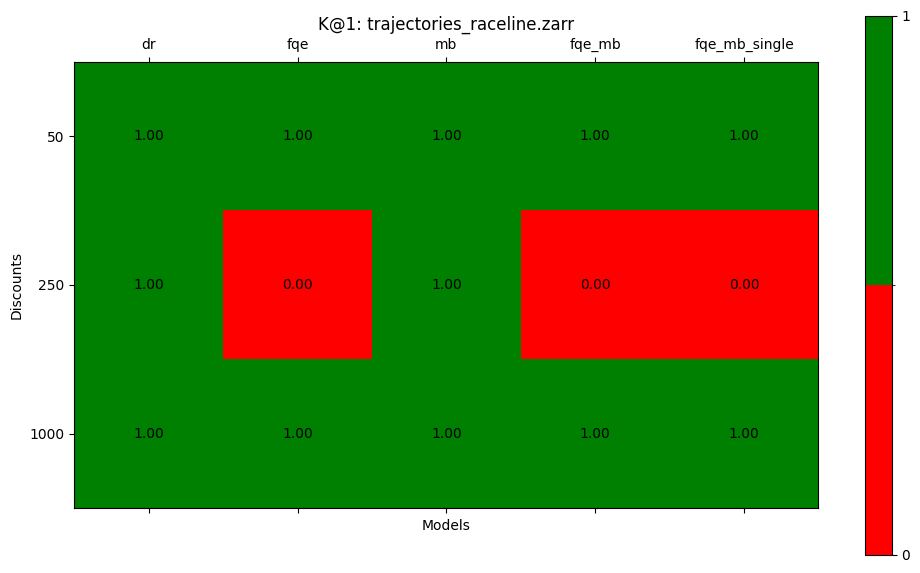

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 0 0]]
['50', '250', '1000']


<Figure size 640x480 with 0 Axes>

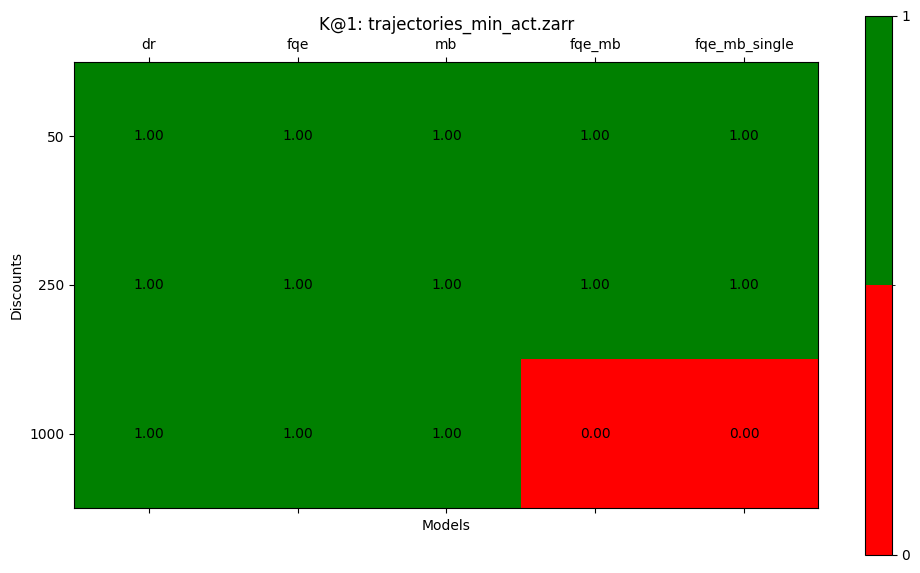

<Figure size 640x480 with 0 Axes>

In [134]:
import plot_utilities as pu
import importlib
# To reload the module:
importlib.reload(pu)
pu.plot_k1(all_rewards, 
                 target_rewards=["trajectories_td_prog.zarr", "trajectories_raceline.zarr", "trajectories_min_act.zarr"],
                 methods=["dr", "fqe", "mb", "fqe_mb", "fqe_mb_single"],
                 lengths=lengths)

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
['50', '250', '1000']


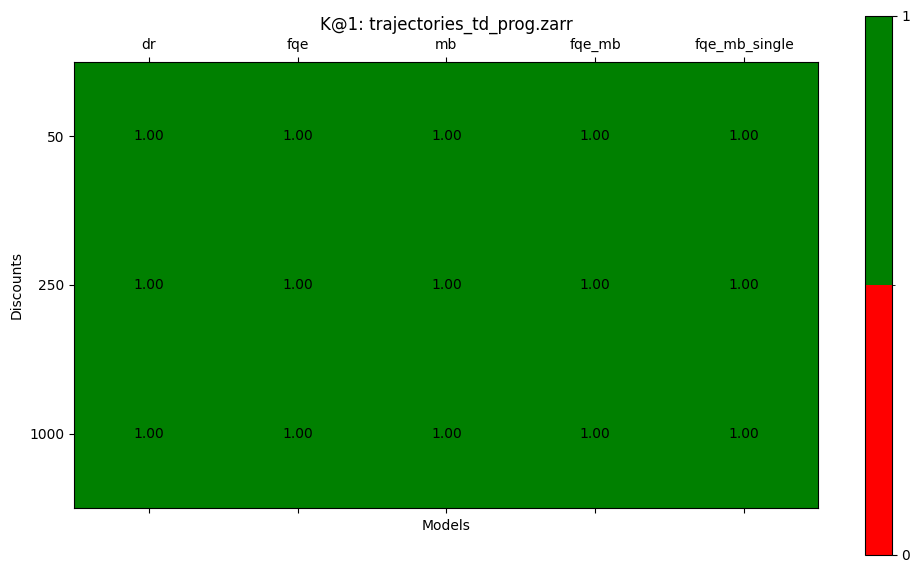

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])
[[1 1 1 1 1]
 [1 0 1 0 0]
 [1 1 1 1 1]]
['50', '250', '1000']


<Figure size 640x480 with 0 Axes>

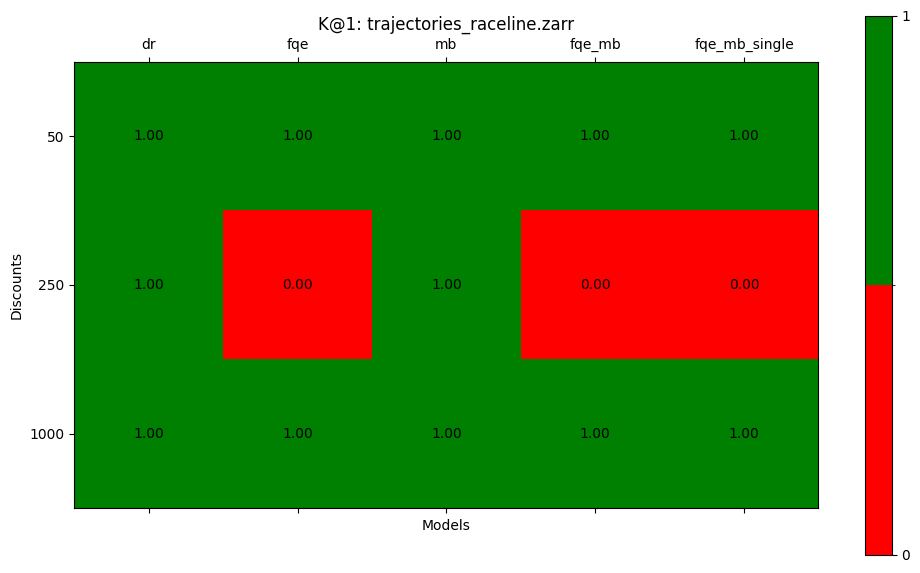

dict_keys(['progress_weight', 'raceline_delta_weight', 'min_action_weight'])
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 0 0]]
['50', '250', '1000']


<Figure size 640x480 with 0 Axes>

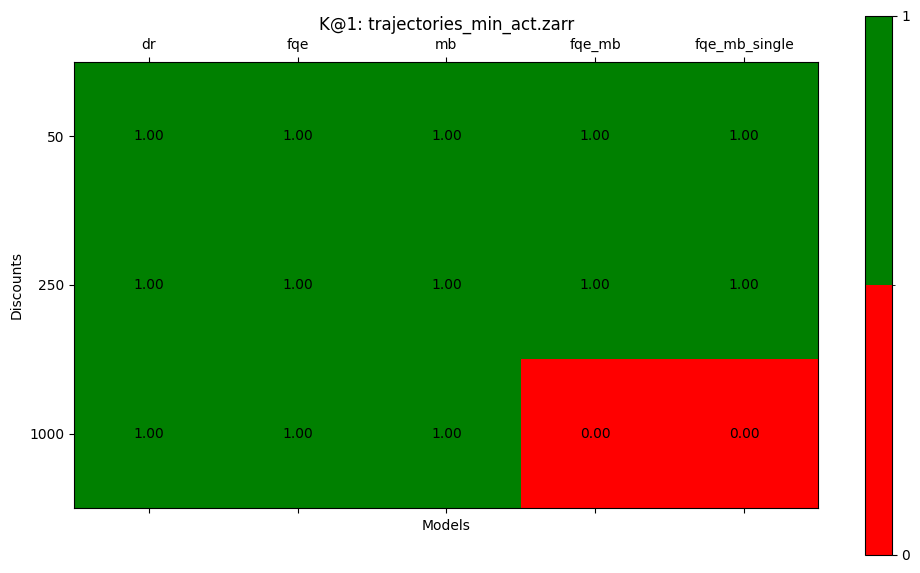

<Figure size 640x480 with 0 Axes>

In [135]:
import plot_utilities as pu
import importlib
# To reload the module:
importlib.reload(pu)
pu.plot_k1(all_rewards, 
                 target_rewards=["trajectories_td_prog.zarr", "trajectories_raceline.zarr", "trajectories_min_act.zarr"],
                 methods=["dr", "fqe", "mb", "fqe_mb", "fqe_mb_single"],
                 lengths=lengths)